# Survival Analysis
By Josh Houlding

It is important to have experience analyzing data where time to a given event is the dependent variable. The task will be to compare the survival distribution between groups, estimate the survival distribution, and model the effect of explanatory variables on the outcome variable. Then, differentiate between the use of the Poisson distribution to estimate the rate of event occurrence and survival analysis to estimate time lapse between events.

For this activity, perform the following:

# Task 1
* Access the <a href="https://archive.ics.uci.edu/dataset/38/echocardiogram">"Echocardiogram Data Set"</a>, located in the topic Resources.
* Using the topic Resources, familiarize yourself with the differences between survival analysis and the Poisson distribution, with an emphasis on parameter estimation (e.g. λ = E(X)).
* Explore the data, perform initial descriptive statistics tests, and explain and visualize your findings. Use the kable() function to visualize the data.
* Formulate a question that can be answered by performing survival analysis.

In [41]:
# Import basic libraries
import pandas as pd 
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt

# Import modeling libraries
from lifelines import KaplanMeierFitter

# Import diagnostic libraries
from lifelines.statistics import logrank_test

### Loading, viewing and cleaning the data

In [42]:
# Load and view data
df = pd.read_csv("echocardiogram.csv")
df.head()

,survival,still_alive,age_at_heart_attack,pericardial_effusion,fractional_shortening,epss,lvdd,wall_motion_score,wall_motion_index,mult,name,group,alive_at_1,Unnamed: 13
0,11,0,71,0,0.26,9,4.6,14,1,1,name,1,0,NaN
1,19,0,72,0,0.38,6,4.1,14,1.7,0.588,name,1,0,NaN
2,16,0,55,0,0.26,4,3.42,14,1,1,name,1,0,NaN
3,57,0,60,0,0.253,12.062,4.603,16,1.45,0.788,name,1,0,NaN
4,19,1,57,0,0.16,22,5.75,18,2.25,0.571,name,1,0,NaN


In [43]:
# Drop unnamed column
df = df.drop(columns={"Unnamed: 13"})

<b>Column info (Acquired from UCI ML repo. dataset page)</b>
 1. `survival`: the number of months patient survived (has survived, if patient is still alive).  Because all the patients had their heart attacks at different times, it is possible that some patients have survived less than one year but they are still alive.  Check the second variable to confirm this.  Such patients cannot be used for the prediction task mentioned above.
   2. `still_alive`: a binary variable.  0=dead at end of survival period, 1 means still alive 
   3. `age_at_heart_attack`: age in years when heart attack occurred
   4. `pericardial_effusion`: binary. Pericardial effusion is fluid around the heart.  0=no fluid, 1=fluid
   5. `fractional_shortening`: a measure of contracility around the heart lower numbers are increasingly abnormal
   6. `epss`: E-point septal separation, another measure of contractility.  Larger numbers are increasingly abnormal.
   7. `lvdd`: left ventricular end-diastolic dimension.  This is a measure of the size of the heart at end-diastole. Large hearts tend to be sick hearts.
   8. `wall_motion_score`: a measure of how the segments of the left ventricle are moving
   9. `wall_motion_index`: equals wall-motion-score divided by number of segments seen.  Usually 12-13 segments are seen in an echocardiogram.  Use this variable INSTEAD of the wall motion score.
   10. `mult`: a derivate var which can be ignored
   11. `name`: the name of the patient (I have replaced them with "name")
   12. `group`: meaningless, ignore it
   13. `alive_at_1`: Boolean-valued. Derived from the first two attributes. 0 means patient was either dead after 1 year or had been followed for less than 1 year.  1 means patient was alive at 1 year.

In [44]:
# Drop "wall_motion_score" since "wall_motion_index" can be used instead
df.drop(columns={"wall_motion_score"}, inplace=True)

# Drop irrelevant or useless columns "mult" and "name"
df.drop(columns={"mult", "name"}, inplace=True)

In [45]:
# Rename "alive_at_1" to _alive_at_1_year" for clarity
df.rename(columns={"alive_at_1": "alive_at_1_year"}, inplace=True)

In [46]:
# Replace missing value placeholders "?" with NaN
df.replace("?", np.nan, inplace=True)

# Replace blank values with NaN
df.replace("", np.nan, inplace=True)

In [47]:
# View missing value counts
df.isna().sum().to_frame().transpose()

,survival,still_alive,age_at_heart_attack,pericardial_effusion,fractional_shortening,epss,lvdd,wall_motion_index,group,alive_at_1_year
0,2,1,6,0,8,15,11,2,22,57


In [48]:
# Strip white spaces from all object columns
for col in df.columns: 
    if df[col].dtype == "O": 
        df[col] = df[col].str.strip()

In [49]:
# Replace all missing values with the mode of the column
for col in df.columns: 
    mode = df[col].mode().iloc[0]
    df[col] = df[col].fillna(mode)

In [50]:
# View missing value counts
df.isna().sum().to_frame().transpose()

,survival,still_alive,age_at_heart_attack,pericardial_effusion,fractional_shortening,epss,lvdd,wall_motion_index,group,alive_at_1_year
0,0,0,0,0,0,0,0,0,0,0


In [51]:
# Check datatypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   survival               132 non-null    object
 1   still_alive            132 non-null    object
 2   age_at_heart_attack    132 non-null    object
 3   pericardial_effusion   132 non-null    int64 
 4   fractional_shortening  132 non-null    object
 5   epss                   132 non-null    object
 6   lvdd                   132 non-null    object
 7   wall_motion_index      132 non-null    object
 8   group                  132 non-null    object
 9   alive_at_1_year        132 non-null    object
dtypes: int64(1), object(9)
memory usage: 10.4+ KB


In [52]:
# Convert datatypes
df["survival"] = df["survival"].astype(float)
df["still_alive"] = df["still_alive"].astype(int)

df["age_at_heart_attack"] = df["age_at_heart_attack"].astype(float)
df["age_at_heart_attack"] = np.floor(df["age_at_heart_attack"])
df["age_at_heart_attack"] = df["age_at_heart_attack"].astype(int)

df["fractional_shortening"] = df["fractional_shortening"].astype(float)
df["epss"] = df["epss"].astype(float)
df["lvdd"] = df["lvdd"].astype(float)
df["wall_motion_index"] = df["wall_motion_index"].astype(float)
df["alive_at_1_year"] = df["alive_at_1_year"].astype(int)

In [53]:
# View updated datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   survival               132 non-null    float64
 1   still_alive            132 non-null    int32  
 2   age_at_heart_attack    132 non-null    int32  
 3   pericardial_effusion   132 non-null    int64  
 4   fractional_shortening  132 non-null    float64
 5   epss                   132 non-null    float64
 6   lvdd                   132 non-null    float64
 7   wall_motion_index      132 non-null    float64
 8   group                  132 non-null    object 
 9   alive_at_1_year        132 non-null    int32  
dtypes: float64(5), int32(3), int64(1), object(1)
memory usage: 8.9+ KB


In [54]:
# Replace erroneous "alive_at_1_year" value
df["alive_at_1_year"] = np.where(df["alive_at_1_year"] > 1, 1, df["alive_at_1_year"])

In [55]:
# Replace erroneous "group" value
df["group"] = np.where(df["group"] == "name", df["group"].mode(), df["group"])

# Convert "group" to numeric
df["group"] = df["group"].astype(int)

The "Additional Variable Information" part of the UCI ML Repository page for the dataset says this about the `survival` variable:<br><br>
<span style="color:red">"Because all the patients had their heart attacks at different times, it is possible that some patients have survived less than one year but they are still alive.  Check the second variable to confirm this.  Such patients cannot be used for the prediction task mentioned above."</span>

Thus, we need to eliminate the entries where `still_alive` = 1 and `alive_at_1_year` = 0 to get rid of patients who are still alive but haven't survived for a year yet. 

In [56]:
# Eliminate entries not useful for prediction
still_alive = df["still_alive"] == 1
hasnt_lived_1_year = df["alive_at_1_year"] == 0
df = df[~(still_alive & hasnt_lived_1_year)]

In [57]:
# Reset indices
df = df.reset_index(drop=True)

<b>Explore the data, perform initial descriptive statistics tests, and explain and visualize your findings. Use the kable() function to visualize the data.</b>

First, let's look at histograms for each variable in the dataset to get a feel for their distributions. 

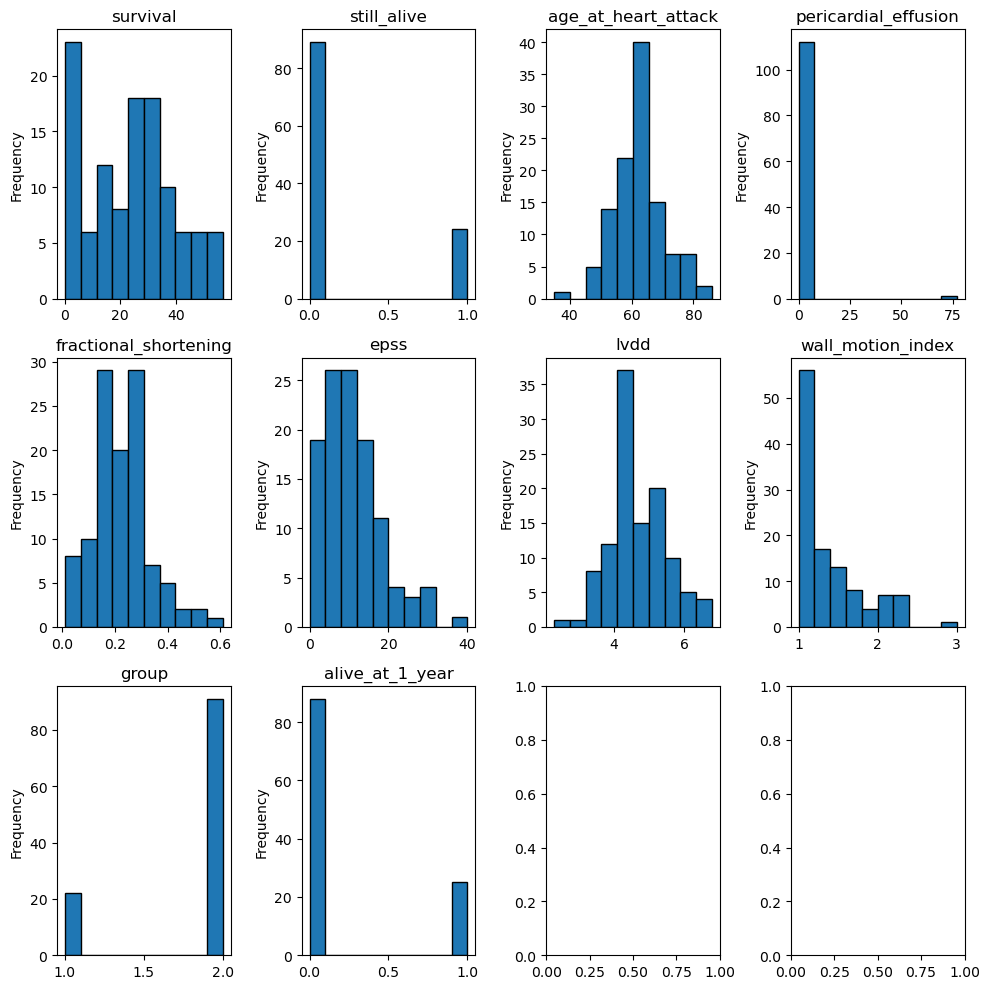

In [58]:
# Set up figure and axes
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10,10))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(df.columns): 
    df[col].plot(kind="hist", ax=axes[i], title=col, edgecolor="black")
    axes[i].set_ylabel("Frequency")

# Display plots
plt.tight_layout()
plt.show()

For `survival`, we see that a substantial number of patients died within the first 5 months, but it follows a somewhat normal distribution overall. We see that `age_at_heart_attack`, `fractional_shortening`, and `lvdd` follow an approximately normal distribution as well. The histogram for `alive_at_1_year` shows that the majority of patients did not make it past the first year. 

Next, let's take a look at descriptive statistics for each variable. 

In [59]:
# Provide descriptive statistics
df.describe()

,survival,still_alive,age_at_heart_attack,pericardial_effusion,fractional_shortening,epss,lvdd,wall_motion_index,group,alive_at_1_year
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,23.739204,0.212389,62.433628,0.858407,0.220354,10.398035,4.692239,1.362097,1.805310,0.221239
std,15.806552,0.410821,8.180853,7.236894,0.106739,7.895302,0.801184,0.428349,0.397726,0.416930
min,0.030000,0.000000,35.000000,0.000000,0.010000,0.000000,2.320000,1.000000,1.000000,0.000000
25%,11.000000,0.000000,57.000000,0.000000,0.150000,5.500000,4.230000,1.000000,2.000000,0.000000
50%,25.000000,0.000000,62.000000,0.000000,0.217000,9.400000,4.510000,1.200000,2.000000,0.000000
75%,34.000000,0.000000,66.000000,0.000000,0.272000,13.600000,5.250000,1.510000,2.000000,0.000000
max,57.000000,1.000000,86.000000,77.000000,0.610000,40.000000,6.780000,3.000000,2.000000,1.000000


### Formulating the research question
<b>Formulate a question that can be answered by performing survival analysis.</b>

Research question: What is the overall survival rate among patients who had heart attacks? 

# Task 2
Calculate the Kaplan-Meier Estimator in Python:

1. Import the lifelines and matplotlib packages.
2. Explore the KaplanMeierFitter filter and build a kmf object using the response variable.
3. Print the kmf object you generated.
4. Analyze the data with the kmf.fit().
5. Generate a KM curve.

<b>Explore the KaplanMeierFitter filter and build a kmf object using the response variable.</b><br>
<b>Print the kmf object you generated.</b><br>
<b>Analyze the data with the kmf.fit().</b>

In [60]:
# Build kmf object
kmf = KaplanMeierFitter()
kmf.fit(durations=df["survival"], event_observed=df["alive_at_1_year"])

# Print kmf object
print(kmf)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 113 total observations, 88 right-censored observations>


Our Kaplan-Meier estimate includes 88 right-censored observations out of 113 total, meaning that ~78% of our patients did not reach the 1-year mark within the given time frame, and the remaining patients did. 

<b>Generate a KM curve.</b>

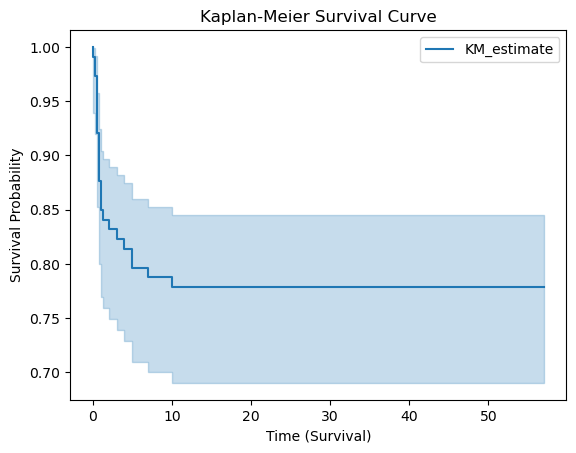

In [61]:
# Plot Kaplan-Meier survival curve
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (Survival)")
plt.ylabel("Survival Probability")
plt.show()

We see that the survival probability stabilizes around 78%, which is the approximate percentage of patients who made it to the 1-year mark. 

# Task 3
Visualize Survival Data:

1. Familiarize yourself with the matplotlib package.
2. Create a detailed, visually appealing plot of the data using kmf.plot(title=’Kaplan-Meier Survival Curve’, xlabel=’Time’, ylabel=’Survival Probability’).

In [62]:
# Create detailed and visually appealing plot of the data
# kmf.plot(title="Kaplan-Meier Survival Curve", xlabel="Time", ylabel="Survival Probability")

The line of code that is commented out right above this generated a plot identical to the KM survival curve rendered in the previous task, so I commented it out to cut down on redundancy. 

# Task 4
Generate K-M Curves with the Predictor:

1. Stratify the analysis into standard vs. experimental using fit method with strata parameter.
2. Display the strata using print().
3. Plot the strata using plot().
4. Plot the overall survival, stratified by the appropriate variable.

<b>Stratify the analysis into standard vs. experimental using fit method with strata parameter.</b><br>
<b>Display the strata using print().</b>

I tried using the `strata` parameter within `kmf.fit()`, but this was met with the following error: 

<span style="color:red">TypeError:</span> KaplanMeierFitter.fit() got an unexpected keyword argument 'strata'

Thus, I had to use a workaround to stratify the data. 

In [63]:
# Stratify analysis by "group"
groups = df["group"].unique()
print(f"Unique groups: {groups}")

# Create a separate KaplanMeierFitter object for each group
kmfs = {}
for group in groups: 
    kmfs[group] = KaplanMeierFitter()
    print(f"Kaplan-Meier Fitter for group {group}:", kmfs[group])
    data_group = df[df["group"] == group]
    kmfs[group].fit(durations=data_group["survival"], event_observed=data_group["alive_at_1_year"], label=group)

Unique groups: [1 2]
Kaplan-Meier Fitter for group 1: <lifelines.KaplanMeierFitter>
Kaplan-Meier Fitter for group 2: <lifelines.KaplanMeierFitter>


<b>Plot the strata using plot().</b>

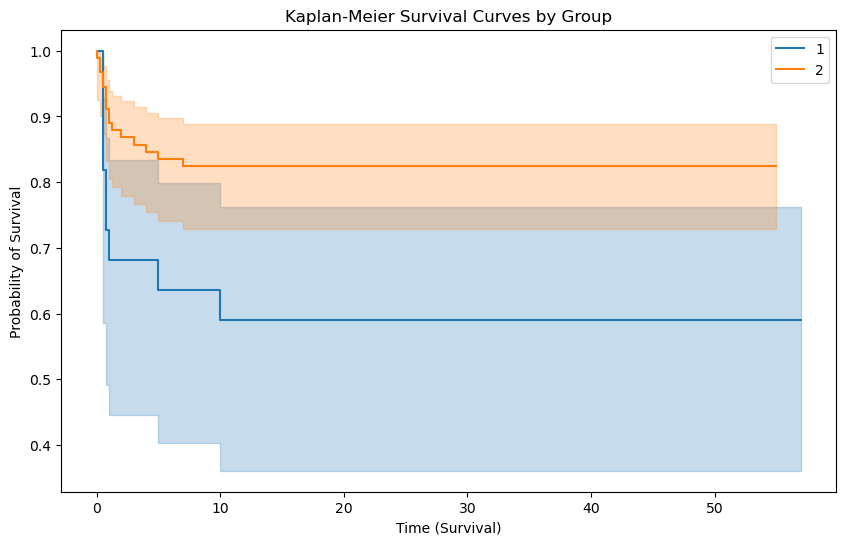

In [64]:
# Plot Kaplan-Meier survival curves for each group
plt.figure(figsize=(10,6))
for group, kmf in kmfs.items(): 
    kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curves by Group")
plt.xlabel("Time (Survival)")
plt.ylabel("Probability of Survival")
plt.legend()
plt.show()

We notice that group 1 has a substantially lower probability of survival than group 2 after about the 2-month mark. 

<b>Plot the overall survival, stratified by the appropriate variable.</b>

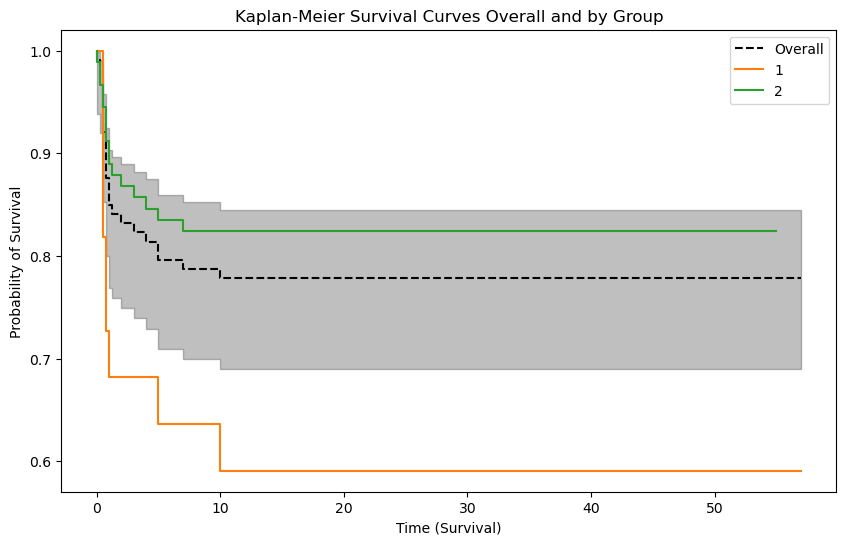

In [65]:
# Create fitter for overall survival
kmf_overall = KaplanMeierFitter()

# Fit overall survival using all data
kmf_overall.fit(durations=df["survival"], event_observed=df["alive_at_1_year"], label="Overall")

# Plot overall survival curve
plt.figure(figsize=(10,6))
kmf_overall.plot_survival_function(color="black", linestyle="dashed")

# Plot survival curve for each group
for group, kmf in kmfs.items(): 
    kmf.plot_survival_function(ci_show=False, label=group) 
plt.title("Kaplan-Meier Survival Curves Overall and by Group")
plt.xlabel("Time (Survival)")
plt.ylabel("Probability of Survival")
plt.legend()
plt.show()

We see that the overall survival curve is much closer to group 2's than group 1's, probably because group 2 is much larger than group 1. 

In [66]:
# Show group sizes
df["group"].value_counts()

group
2    91
1    22
Name: count, dtype: int64

# Task 4
Perform Log-Rank Analysis:
1. Familiarize yourself with the logrank_test().
2. Test the difference between survival curves using results = logrank_test(durations_A, durations_B, event_observed_A=event_A, event_observed_B=event_B).
3. Examine and interpret the log-rank output.
4. Plot the K-M curve and include the log-rank test.

<b>Test the difference between survival curves using</b> `results = logrank_test(durations_A, durations_B, event_observed_A=event_A, event_observed_B=event_B)`.

Log-Rank test details 
* $H_0$: The survival curves for each group are identical (no difference in survival rate). 
* $H_a$: There is a difference in survival among each group. 
* $\alpha = 0.05.$

In [67]:
# Perform log-rank test
result = logrank_test(durations_A = df.loc[df["group"] == 1, "survival"],
                     durations_B = df.loc[df["group"] == 2, "survival"],
                     event_observed_A = df.loc[df["group"] == 1, "alive_at_1_year"],
                     event_observed_B = df.loc[df["group"] == 2, "alive_at_1_year"])

<b>Examine and interpret the log-rank output.</b>

In [68]:
# Display result
result

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.94 0.01      6.08

We get a P-value of $0.01$, far below $\alpha = 0.05$, so we reject $H_0$ and conclude that there is a difference in survival rates between the groups.  

<b>Plot the K-M curve and include the log-rank test.</b>

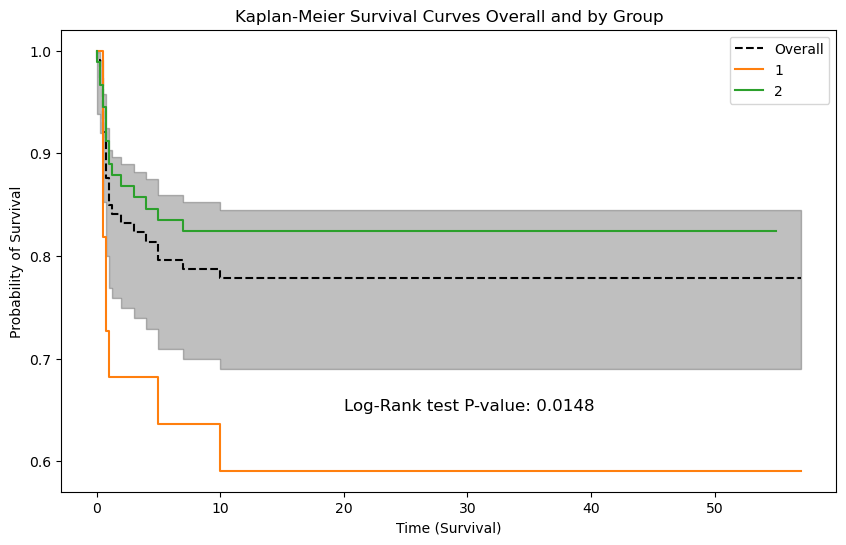

In [69]:
# Plot overall survival curve
plt.figure(figsize=(10,6))
kmf_overall.plot_survival_function(color="black", linestyle="dashed")

# Plot survival curve for each group
for group, kmf in kmfs.items(): 
    kmf.plot_survival_function(ci_show=False, label=group) 
plt.title("Kaplan-Meier Survival Curves Overall and by Group")
plt.xlabel("Time (Survival)")
plt.ylabel("Probability of Survival")
plt.text(20, 0.65, f"Log-Rank test P-value: {result.p_value:.4f}", fontsize=12)
plt.legend()
plt.show()

# Task 5
<b>Were you able to answer the question you formulated? If yes, state the answer and explain. If no, continue the analysis until you can answer the question.</b>

I was certainly able to answer my original research question of "What is the overall survival rate among patients who had heart attacks?". The overall survival curve (dashed black line on the plots) shows that the probability of survival drops precipitously at about the 2-month mark and stabilizes around 0.78 (78%) around the 10-month mark. This means that if a heart attack victim survives to the 10-month mark, odds are good that they will live for many more months. 

# References
Van Paemel, R. (2021, December 9). Kaplan Meier curves: an introduction - Towards Data Science. Medium. https://towardsdatascience.com/kaplan-meier-curves-c5768e349479 <br>
ChatGPT. (n.d.). https://chat.openai.com/ <br>
Bing AI - Bing. (n.d.-a). Bing. https://www.bing.com/search?toncp=0&FORM=hpcodx&q=Bing+AI&showconv=1